In [1]:
from artifacts_ipv6_sra_scanning.config import *
import pickle
import os
import ipaddress
import geopandas as gpd
import glob
import pycountry
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
from parallel_pandas import ParallelPandas
ParallelPandas.initialize(n_cpu=24, split_factor=1, disable_pr_bar=False)

2025-09-27 07:39:29.136 | INFO     | artifacts_ipv6_sra_scanning.config:<module>:22 - PROJ_ROOT path is: /home/service/artifacts-ipv6-sra-scanning


In [2]:
df = pl.read_parquet(f'{PROCESSED_DATA_DIR}/sra_tum_scans_stability.parquet')
df_metadata = pl.read_csv(f'{INTERIM_DATA_DIR}/router-ips.csv')

In [3]:
df.head()

initial-ip,saddr,classification,saddr_s1,classification_s1,saddr_s2,classification_s2,saddr_s3,classification_s3,saddr_s4,classification_s4,saddr_s5,classification_s5
str,str,str,str,str,str,str,str,str,str,str,str,str
"""240e:358:e00:6b54::""","""240e:358:e00:6b54:7869:e171:7f…","""echoreply""","""240e:358:e00:6b54:7869:e171:7f…","""echoreply""","""240e:358:e00:6b54:7869:e171:7f…","""echoreply""",null,null,null,null,null,null
"""2409:40e4:8:7db2::""","""2409:40e4:8:7db2:5e2f:65c5:7b5…","""unreach_noroute""","""2409:40e4:8:7db2:5e2f:65c5:7b5…","""unreach_noroute""","""2409:40e4:8:7db2:5e2f:65c5:7b5…","""unreach_noroute""",null,null,null,null,null,null
"""2001:1670:10:6362::""","""2001:1670:10:6362:1008:d0df:88…","""echoreply""","""2001:1670:10:6362:1008:d0df:88…","""echoreply""","""2001:1670:10:6362:1008:d0df:88…","""echoreply""","""2001:1670:14:0:40a4:5e47:67f0:…","""unreach_addr""","""2001:1670:10:6362:4dbb:9498:1d…","""echoreply""","""2001:1670:10:6362:4dbb:9498:1d…","""echoreply"""
"""2003:e3:3719:2e00::""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin"""
"""2400:2412:4761:b600::""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply"""


In [4]:
df_metadata.head()

ip-addr,Geo,AS-Number,BGP-Prefix,Org
str,str,f64,str,str
"""2402:b400:4440:53ef:c822:8bff:…","""MYS""",45960.0,"""2402:b400:4440::/46""","""YTLCOMMS-AS-AP YTL COMMUNICATI…"
"""2003:e6:37ff:3ab2:3ea6:2fff:fe…","""DEU""",3320.0,"""2003::/19""","""DTAG Internet service provider…"
"""2405:8d40:4081:579:1807:c46a:e…","""PHL""",139831.0,"""2405:8d40:4080::/42""","""DTC-AS-AP DITO TELECOMMUNITY C…"
"""240e:358:9c0a:13ec:ae64:62ff:f…","""CHN""",4134.0,"""240e:358::/29""","""CHINANET-BACKBONE No.31,Jin-ro…"
"""2408:8441:5808:10fa:1807:f6b5:…","""CHN""",4837.0,"""2408:8441::/32""","""CHINA169-BACKBONE CHINA UNICOM…"


In [5]:
df = df.join(df_metadata.select(['ip-addr','AS-Number']),how='left',left_on='saddr',right_on='ip-addr')

In [6]:
df = df.join(df_metadata.select(['ip-addr','AS-Number']),how='left',left_on='saddr_s1',right_on='ip-addr',suffix='_s1')

In [7]:
df = df.join(df_metadata.select(['ip-addr','AS-Number']),how='left',left_on='saddr_s2',right_on='ip-addr',suffix='_s2')

In [8]:
df = df.join(df_metadata.select(['ip-addr','AS-Number']),how='left',left_on='saddr_s3',right_on='ip-addr',suffix='_s3')

In [9]:
df = df.join(df_metadata.select(['ip-addr','AS-Number']),how='left',left_on='saddr_s4',right_on='ip-addr',suffix='_s4')

In [10]:
df = df.join(df_metadata.select(['ip-addr','AS-Number']),how='left',left_on='saddr_s5',right_on='ip-addr',suffix='_s5')

In [11]:
df.head()

initial-ip,saddr,classification,saddr_s1,classification_s1,saddr_s2,classification_s2,saddr_s3,classification_s3,saddr_s4,classification_s4,saddr_s5,classification_s5,AS-Number,AS-Number_s1,AS-Number_s2,AS-Number_s3,AS-Number_s4,AS-Number_s5
str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64
"""240e:358:e00:6b54::""","""240e:358:e00:6b54:7869:e171:7f…","""echoreply""","""240e:358:e00:6b54:7869:e171:7f…","""echoreply""","""240e:358:e00:6b54:7869:e171:7f…","""echoreply""",null,null,null,null,null,null,4134.0,4134.0,4134.0,null,null,null
"""2409:40e4:8:7db2::""","""2409:40e4:8:7db2:5e2f:65c5:7b5…","""unreach_noroute""","""2409:40e4:8:7db2:5e2f:65c5:7b5…","""unreach_noroute""","""2409:40e4:8:7db2:5e2f:65c5:7b5…","""unreach_noroute""",null,null,null,null,null,null,55836.0,55836.0,55836.0,null,null,null
"""2001:1670:10:6362::""","""2001:1670:10:6362:1008:d0df:88…","""echoreply""","""2001:1670:10:6362:1008:d0df:88…","""echoreply""","""2001:1670:10:6362:1008:d0df:88…","""echoreply""","""2001:1670:14:0:40a4:5e47:67f0:…","""unreach_addr""","""2001:1670:10:6362:4dbb:9498:1d…","""echoreply""","""2001:1670:10:6362:4dbb:9498:1d…","""echoreply""",28885.0,28885.0,28885.0,null,null,null
"""2003:e3:3719:2e00::""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""","""2003:e3:37ff:19a5:e228:6dff:fe…","""unreach_admin""",3320.0,3320.0,3320.0,3320.0,3320.0,3320.0
"""2400:2412:4761:b600::""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""","""2400:2412:4761:b601:3ae0:8eff:…","""echoreply""",17676.0,17676.0,17676.0,17676.0,17676.0,17676.0


In [12]:
plt.rc("font", size=12)

In [13]:
for i in range(1, 6):
    col = f"AS-Number_s{i}"
    df = df.with_columns(
        pl.when(pl.col(col).is_null())
          .then(pl.lit("Not seen"))
          .when(pl.col(col) == pl.col("AS-Number"))
          .then(pl.lit("Unchanged"))
          .otherwise(pl.lit("Changed"))
          .alias(f"{col}_status")
    )

In [20]:
df = df.filter(pl.col('AS-Number').is_not_null())

In [21]:
status_cols = [f"AS-Number_s{i}_status" for i in range(1, 6)]

# Melt the dataframe to long format
df_long = df.unpivot(
    index=[],           # no id vars needed, just counts
    on=status_cols,
    variable_name="stage",
    value_name="status"
)

# Group by stage and status to get counts
df_plot = df_long.group_by(["stage", "status"]).agg(
    pl.len().alias("count")
).sort(["stage", "count"])

In [22]:
df_wide = df_plot.to_pandas().pivot(index='stage', columns='status', values='count')

df_pct = df_wide.div(df_wide.sum(axis=1), axis=0) * 100
df_pct = df_pct[['Unchanged','Not seen','Changed']]

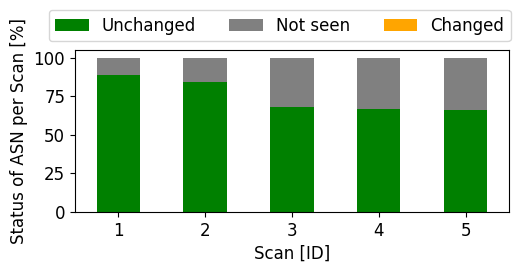

/home/service/artifacts-ipv6-sra-scanning/reports/figures/sra_stability_asn.png


In [23]:
figsize = (8*0.7,3*0.7)
fig,ax = vh.fig_ax(figsize)

df_pct.plot(
    kind='bar', 
    stacked=True,
    color=["green","gray","orange"],
    ax=ax)
ax.set_xlabel('Scan [ID]')
ax.set_ylabel('Status of ASN per Scan [%]')
ax.set_xticks([i for i in range(0,5)],[i for i in range(1,6)],rotation=0)
ax.set_yticks([0,25,50,75,100])
plt.legend(ncols=3,bbox_to_anchor=(-0.08,1.3),loc='upper left')
plt.show()
vh.save_plot(fig,'sra_stability_asn',autoclose=True)

In [24]:
df_pct

status,Unchanged,Not seen,Changed
stage,,,
AS-Number_s1_status,89.029696,10.967226,0.003079
AS-Number_s2_status,84.278620,15.717329,0.004051
AS-Number_s3_status,68.180223,31.814505,0.005272
AS-Number_s4_status,66.545388,33.449662,0.004949
AS-Number_s5_status,66.023514,33.971288,0.005198
